In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

In [ ]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [ ]:
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

train_ds, validation_ds, test_ds = tfds.load(
    "cats_vs_dogs",
    # Reserve 10% for validation and 10% for test
    split=["train[:40%]", "train[40%:50%]", "train[50%:60%]"],
    as_supervised=True,  # Include labels
)

print("Number of training samples: %d" % tf.data.experimental.cardinality(train_ds))
print(
    "Number of validation samples: %d" % tf.data.experimental.cardinality(validation_ds)
)
print("Number of test samples: %d" % tf.data.experimental.cardinality(test_ds))

Number of training samples: 9305
Number of validation samples: 2326
Number of test samples: 2326


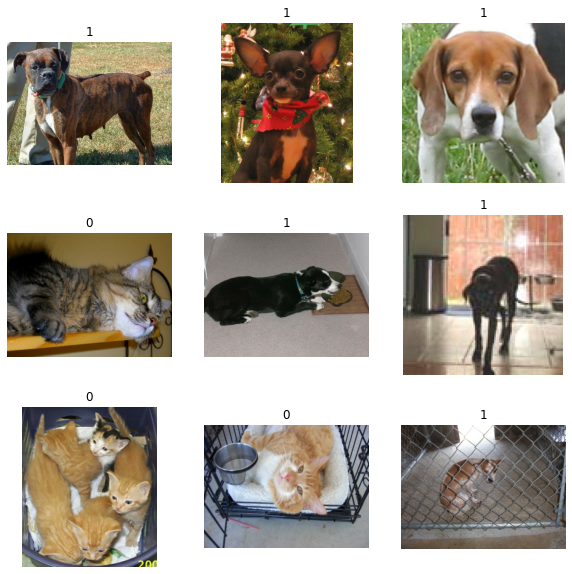

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(train_ds.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(int(label))
    plt.axis("off")

In [ ]:
size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [ ]:
batch_size = 32

train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=10)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=10)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=10)

In [ ]:
from tensorflow.keras import layers

data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)

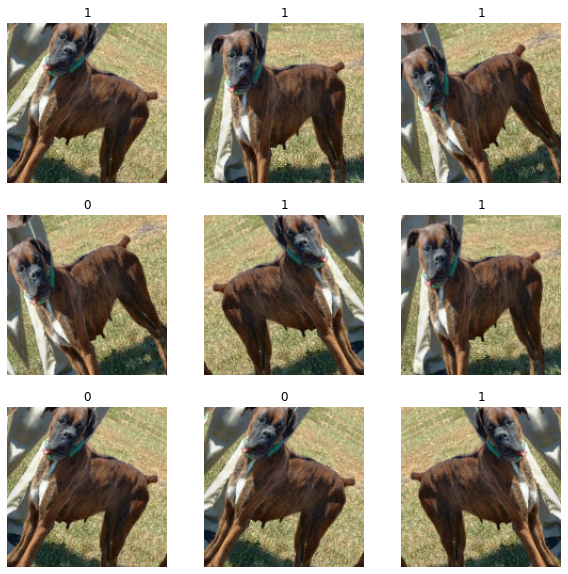

In [ ]:
import numpy as np

for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(
            tf.expand_dims(first_image, 0), training=True
        )
        plt.imshow(augmented_image[0].numpy().astype("int32"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [ ]:
base_model = keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)  # Apply random data augmentation

# Pre-trained Xception weights requires that input be normalized
# from (0, 255) to a range (-1., +1.), the normalization layer
# does the following, outputs = (inputs - mean) / sqrt(var)
norm_layer = keras.layers.experimental.preprocessing.Normalization()
mean = np.array([127.5] * 3)
var = mean ** 2
# Scale inputs to [-1, +1]
x = norm_layer(x)
norm_layer.set_weights([mean, var])

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = keras.layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [ ]:
model.compile(
    optimizer=keras.optimizers.Adam(),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 3
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Epoch 1/3
291/291 [==============================] - 28s 80ms/step - loss: 0.2340 - binary_accuracy: 0.8922 - val_loss: 0.0810 - val_binary_accuracy: 0.9716
Epoch 2/3
291/291 [==============================] - 22s 74ms/step - loss: 0.1328 - binary_accuracy: 0.9419 - val_loss: 0.0746 - val_binary_accuracy: 0.9725
Epoch 3/3
291/291 [==============================] - 22s 75ms/step - loss: 0.1110 - binary_accuracy: 0.9525 - val_loss: 0.0714 - val_binary_accuracy: 0.9725


In [ ]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.
base_model.trainable = True
model.summary()

model.compile(
    optimizer=keras.optimizers.Adam(1e-5),  # Low learning rate
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy()],
)

epochs = 2
model.fit(train_ds, epochs=epochs, validation_data=validation_ds)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 150, 150, 3)       0         
_________________________________________________________________
normalization (Normalization (None, 150, 150, 3)       7         
_________________________________________________________________
xception (Functional)        (None, 5, 5, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2049  

In [ ]:
predictions = model.predict(test_ds)

In [ ]:
predictions

array([[-8.889564],
       [ 7.865121],
       [ 8.950633],
       ...,
       [-3.352493],
       [ 7.051694],
       [ 8.076288]], dtype=float32)

In [ ]:
# Evaluate the best model with testing data.
print(model.evaluate(x=test_ds))

73/73 [==============================] - 4s 58ms/step - loss: 0.0641 - binary_accuracy: 0.9764
[0.06405218690633774, 0.9763542413711548]
